In [13]:
import json
import glob
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
REVAL_DIR = os.path.expanduser('~/reval_50')
sys.path.append('..')
from imports import load

In [7]:
REVAL_DIR

'/home/tgandor/reval_50'

In [9]:
files = glob.glob(f'{REVAL_DIR}/*/*/results.json.gz')
files[:2];

In [14]:
results = [load(f) for f in files]

In [26]:
from itertools import groupby
gb = lambda it, key: groupby(sorted(it, key=key), key)

for key, group in gb(results, lambda x: x['model']):
    print(key, end=' ')

R101 R101_C4 R101_DC5 R101_FPN R50 R50_C4 R50_DC5 R50_FPN X101 

In [29]:
sum(int(r['elapsed']) for r in results)

1098273

In [32]:
def flatten(value):
    result = value.copy()
    aps = {k: v for k, v in result['results']['bbox'].items() if '-' not in k}
    result.update(aps)
    del result['results']
    return result
flatten(results[0])

{'quality': 78,
 'model': 'R101',
 'elapsed': 697.6936926841736,
 'device': 'GeForce GTX 1070',
 'AP': 32.328788100355226,
 'AP50': 45.22097900897498,
 'AP75': 35.618696065563924,
 'APs': 14.19742769547056,
 'APm': 35.81488809154681,
 'APl': 45.72616095438469}

In [34]:
c_df = pd.DataFrame([flatten(r) for r in results]).sort_values(['model', 'quality'])
c_df.head()

,quality,model,elapsed,device,AP,AP50,AP75,APs,APm,APl
51,1,R101,693.785319,GeForce GTX 1070,0.567145,0.965074,0.590782,0.137215,0.469693,1.052001
40,2,R101,694.591488,GeForce GTX 1070,0.570849,0.964498,0.582610,0.142265,0.479448,1.021694
28,3,R101,695.150291,GeForce GTX 1070,0.733096,1.249535,0.707095,0.217234,0.622481,1.339452
47,4,R101,695.592808,GeForce GTX 1070,1.301107,2.057399,1.364771,0.264273,1.336611,1.995320
17,5,R101,696.160201,GeForce GTX 1070,2.251407,3.573598,2.390964,0.424181,2.529039,3.562760


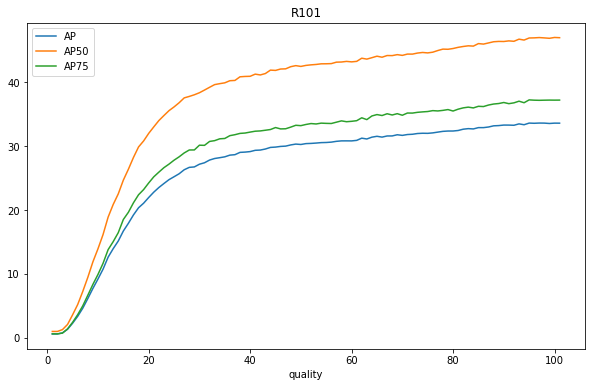

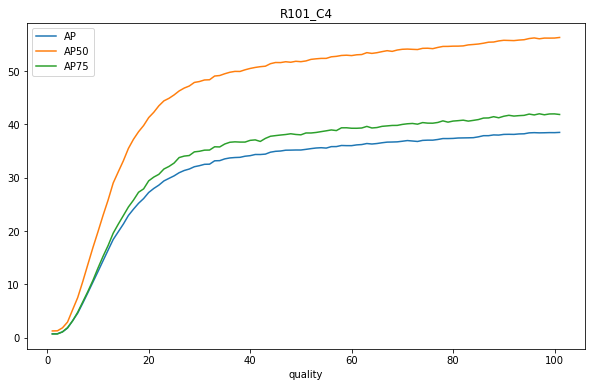

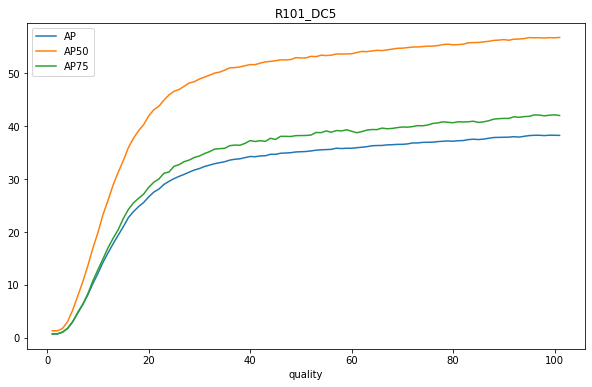

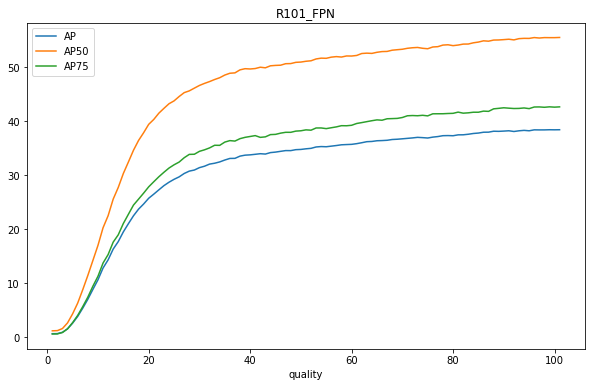

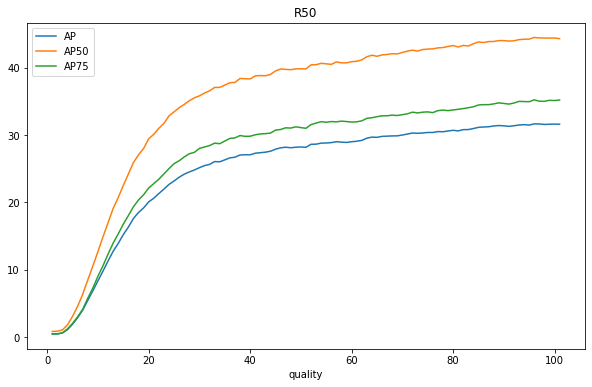

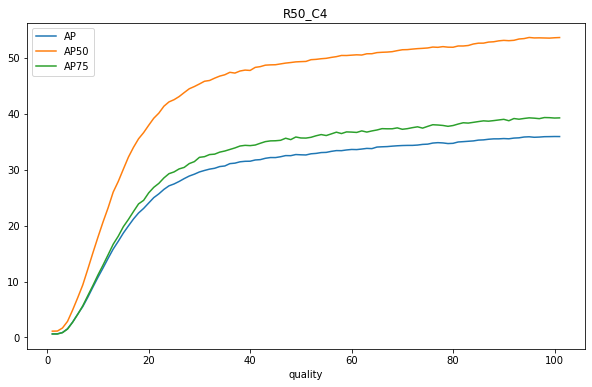

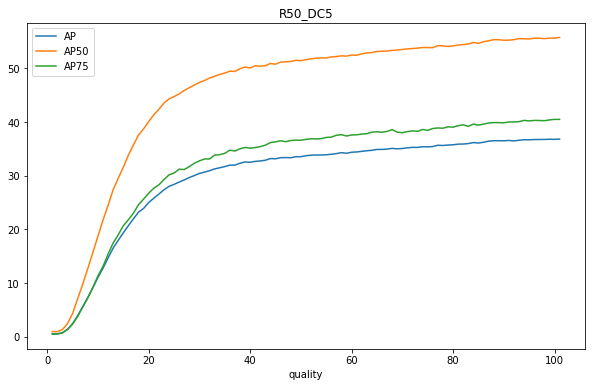

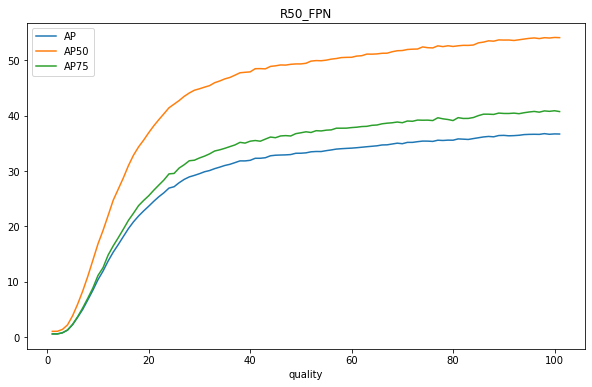

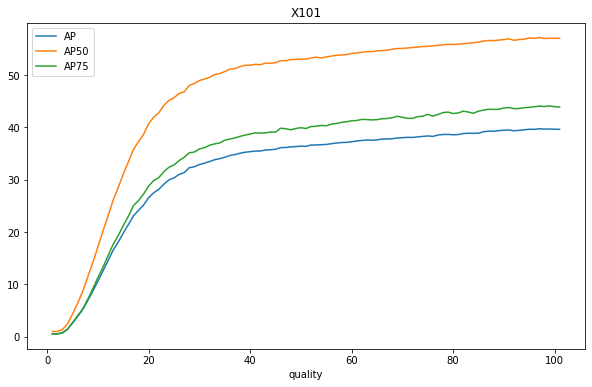

In [35]:
for mc in c_df.model.unique():
    ax = c_df[c_df.model == mc][['quality', 'AP', 'AP50', 'AP75']].plot(x='quality')
    ax.set_title(mc)

In [41]:
avg_pivot = c_df.pivot_table(index='model', values=['AP', 'APl', 'APm', 'APs']).sort_values('AP', ascending=False)
avg_pivot

,AP,APl,APm,APs
model,,,,
X101,31.750981,43.047924,34.626094,16.179287
R101_C4,31.151578,44.985597,34.656815,13.820500
R101_DC5,30.974756,43.514956,34.482016,14.274992
R101_FPN,30.613107,42.431434,33.527600,15.062925
R50_DC5,29.505881,41.424220,32.880312,13.507232
R50_FPN,29.069423,40.293432,31.866892,14.003250
R50_C4,28.736655,41.974839,31.737248,12.488986
R101,26.555697,37.686844,29.477352,10.716540
R50,24.831616,36.097596,27.414568,9.573735


In [143]:
def save_plot(plot, name='', title=None):
    if title:
        plot.set_title(title)
    fig = plot.get_figure()
    fig.set_size_inches(4, 4)
    if name:
        fig.savefig(name)

def plot_models(df, column, norm=False):
    avg_pivot = df.pivot_table(index='model', values=[column]).sort_values(column, ascending=False)
    c_pivot = df.pivot(index='quality', columns='model', values=column).reindex(columns=avg_pivot.index)
    title = f'{column}: all models'
    if norm:
        c_pivot = c_pivot / c_pivot.max(axis=0)
        title += ' (scaled)'
    ax = c_pivot.plot()
    ax.set_title(title)
    return ax


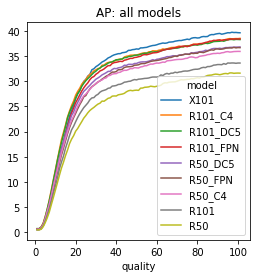

In [138]:
ax = plot_models(c_df, 'AP')
save_plot(ax, 'all_AP_raw.pdf')

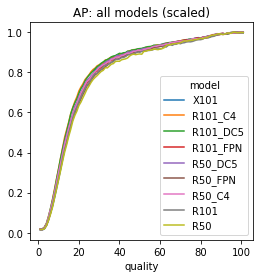

In [139]:
ax = plot_models(c_df, 'AP', True)
save_plot(ax, 'all_AP_scaled.pdf')

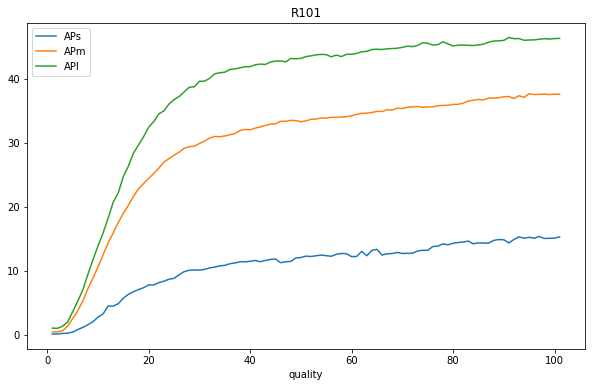

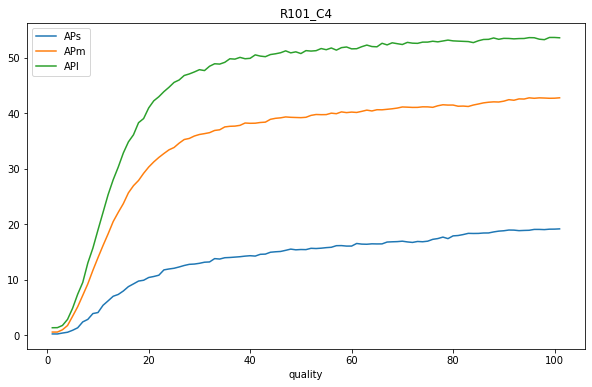

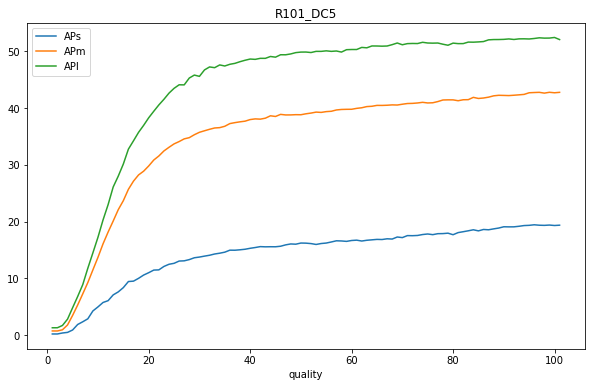

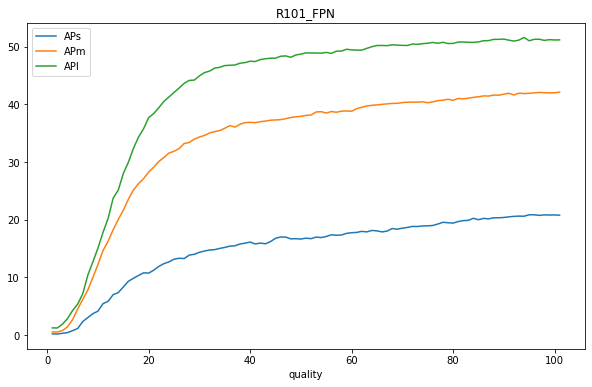

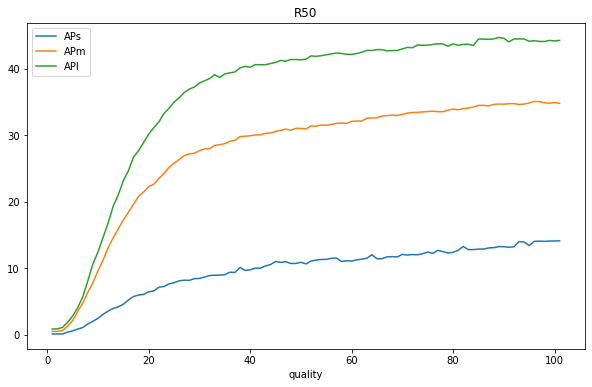

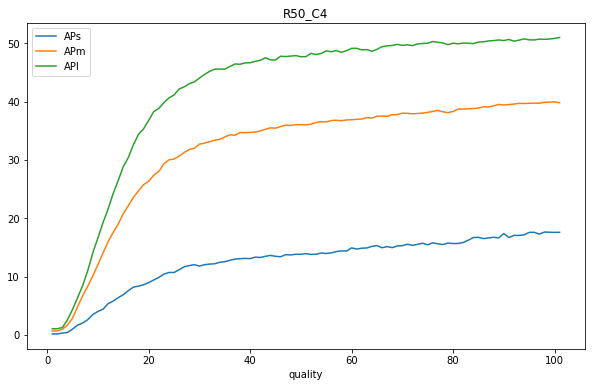

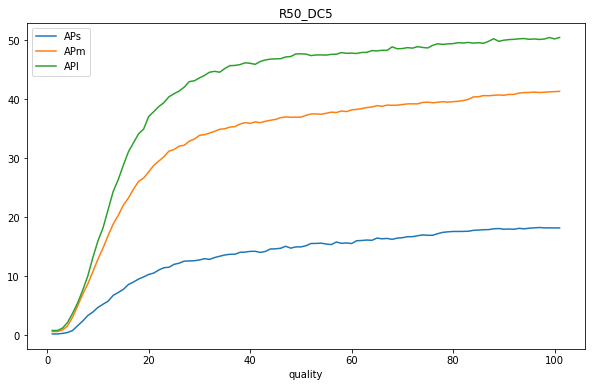

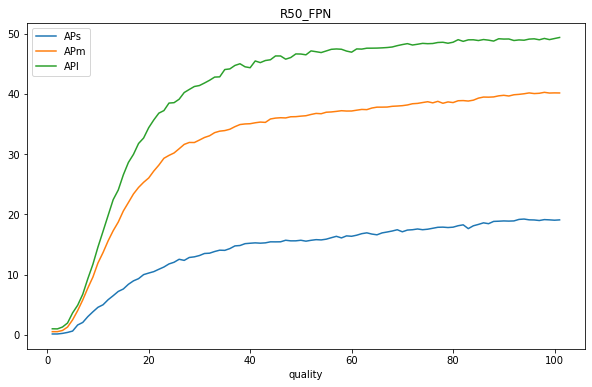

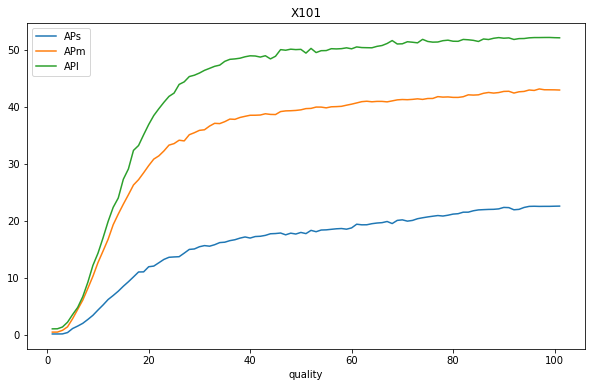

In [72]:
for mc in c_df.model.unique():
    ax = c_df[c_df.model == mc][['quality', 'APs', 'APm', 'APl']].plot(x='quality')
    ax.set_title(mc)

<AxesSubplot:xlabel='quality'>

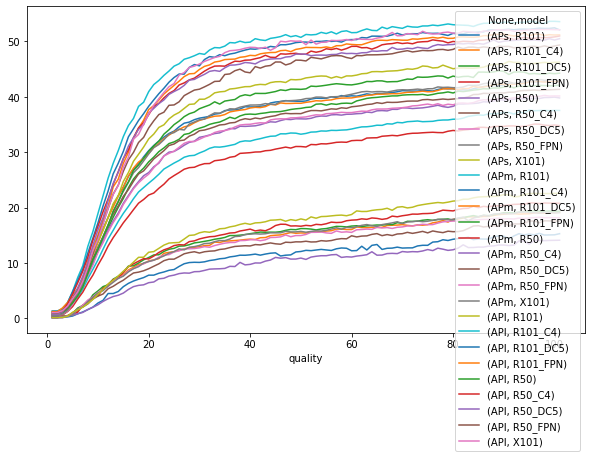

In [47]:
pd.pivot(c_df, index='quality', columns='model', values=['APs', 'APm', 'APl']).plot();

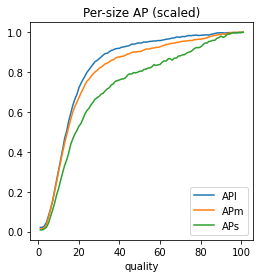

In [144]:
mAPsml = c_df.groupby('quality').agg({x: 'mean' for x in reversed(('APs', 'APm', 'APl'))})
mAPsml = mAPsml / mAPsml.max(axis=0)
plot = mAPsml.plot()
save_plot(plot, 'average_APlms_scaled.pdf', 'Per-size AP (scaled)')

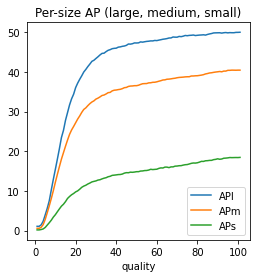

In [146]:
plot = c_df.groupby('quality').agg({x: 'mean' for x in reversed(('APs', 'APm', 'APl'))}).plot()
save_plot(plot, 'average_APlms.pdf', "Per-size AP (large, medium, small)")

In [84]:
rich_files = glob.glob(f'{REVAL_DIR}/*/*/rich_results.json')
rich_files[:2]

['/home/tgandor/reval_50/R101/evaluator_dump_R101_078/rich_results.json',
 '/home/tgandor/reval_50/R101/evaluator_dump_R101_053/rich_results.json']

In [85]:
df = pd.DataFrame(load(f) for f in rich_files).sort_values(['model', 'quality'])
df.head()

,quality,model,elapsed,tp,fp,precision,recall,f1,AP,AP50,AP75,APs,APm,APl
51,1,R101,693.785319,231,293,0.440840,0.006358,0.012534,0.567145,0.965074,0.590782,0.137215,0.469693,1.052001
40,2,R101,694.591488,232,301,0.435272,0.006385,0.012585,0.570849,0.964498,0.582610,0.142265,0.479448,1.021694
28,3,R101,695.150291,346,396,0.466307,0.009522,0.018664,0.733096,1.249535,0.707095,0.217234,0.622481,1.339452
47,4,R101,695.592808,733,532,0.579447,0.020173,0.038989,1.301107,2.057399,1.364771,0.264273,1.336611,1.995320
17,5,R101,696.160201,1473,687,0.681944,0.040539,0.076529,2.251407,3.573598,2.390964,0.424181,2.529039,3.562760


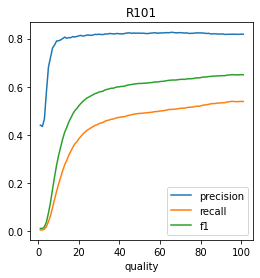

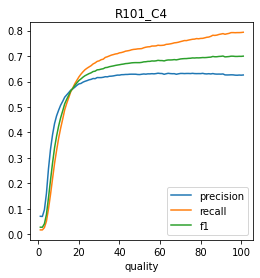

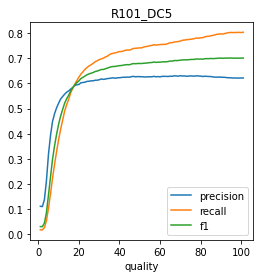

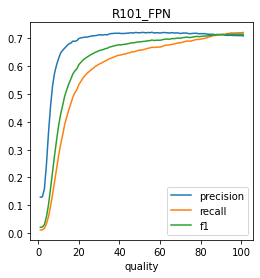

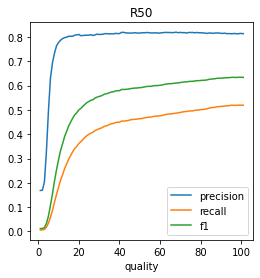

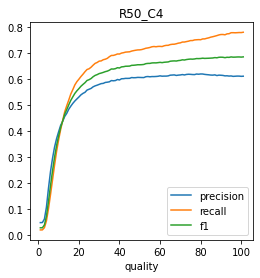

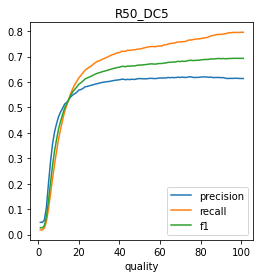

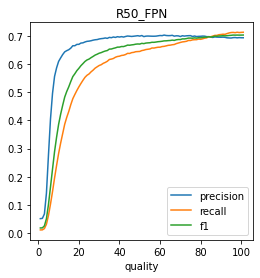

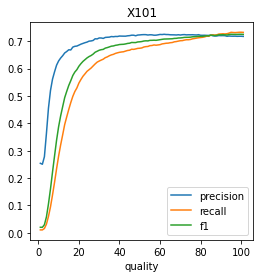

In [98]:
for mc in df.model.unique():
    ax = df[df.model == mc][['quality', 'precision', 'recall', 'f1']].plot(x='quality')
    ax.set_title(mc)
    save_plot(ax, f'{mc}_prf1.pdf')

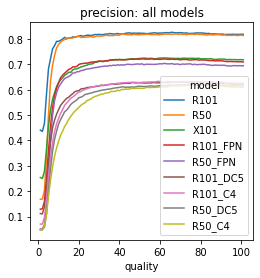

In [96]:
ax = plot_models(df, 'precision')
save_plot(ax, 'all_PPV_raw.pdf')

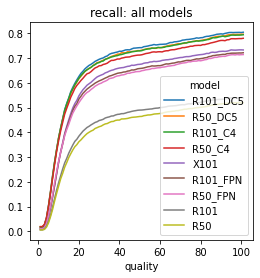

In [95]:
ax = plot_models(df, 'recall')
save_plot(ax, 'all_TPR_raw.pdf')

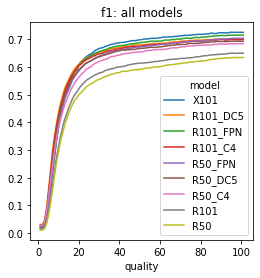

In [97]:
ax = plot_models(df, 'f1')
save_plot(ax, 'all_F1_raw.pdf')

In [100]:
qdf = pd.read_csv('../data/val2017_means_per_Q.csv')
qdf.head(2)

,quality,mean_squared_error,peak_signal_noise_ratio,structural_similarity,filesize,B_per_kpx
0,1,536.18,21.205,0.539,7203.782,9.291
1,2,535.91,21.207,0.539,7207.225,9.295


In [108]:
avgdf = df.groupby('quality').agg('mean')
avgdf.tail(2)

,elapsed,tp,fp,precision,recall,f1,AP,AP50,AP75,APs,APm,APl
quality,,,,,,,,,,,,
100,1167.795457,25812.777778,12496.888889,0.691787,0.710411,0.689443,36.601524,53.349214,40.400493,18.416302,40.475657,50.006381
101,1090.967105,25829.222222,12510.444444,0.691585,0.710863,0.689561,36.603540,53.371720,40.367561,18.458267,40.472502,50.037721


In [116]:
rich = pd.merge(avgdf, qdf, left_index=True, right_index=True)

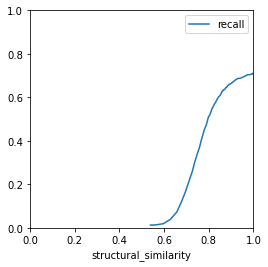

In [135]:
ax = rich.plot(x='structural_similarity', y='recall', xlim=(0, 1), ylim=(0, 1))
save_plot(ax, 'recall_by_ssim.pdf')

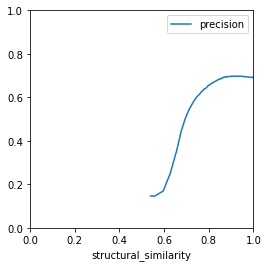

In [120]:
ax = rich.plot(x='structural_similarity', y='precision', xlim=(0, 1), ylim=(0, 1))
save_plot(ax, '')

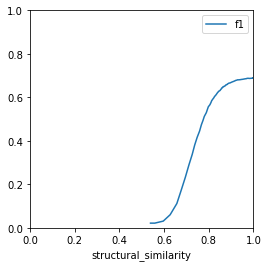

In [136]:
ax = rich.plot(x='structural_similarity', y='f1', xlim=(0, 1), ylim=(0, 1))
save_plot(ax, '')

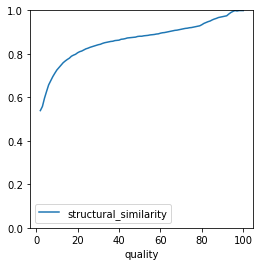

In [148]:
ax = rich.plot(x='quality', y='structural_similarity', ylim=(0, 1))
save_plot(ax, 'SSIM_by_q.pdf')

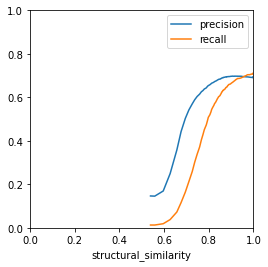

In [147]:
ax = rich[['structural_similarity', 'precision', 'recall']].plot(x='structural_similarity', xlim=(0, 1), ylim=(0, 1))
save_plot(ax, 'pr_by_SSIM.pdf')

In [ ]:
ax = rich.plot(x='structural_similarity', y='recall', xlim=(0, 1), ylim=(0, 1))
save_plot(ax, '')

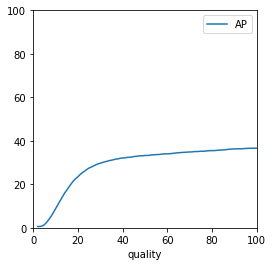

In [133]:
ax = rich.plot(x='quality', y='AP', ylim=(0, 100), xlim=(0, 100))
save_plot(ax, '')

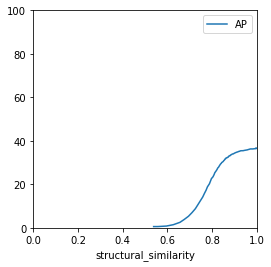

In [149]:
ax = rich.plot(x='structural_similarity', y='AP', xlim=(0, 1), ylim=(0, 100))
save_plot(ax, 'AP_by_SSIM.pdf')

In [158]:
rich.loc[[96, 90, 80, 60, 40, 20], ['AP', 'APl', 'APm', 'APs']].round(1).reset_index?

Object `reset_index` not found.


In [179]:
rich['PPV'] = rich.precision * 100
rich['TPR'] = rich.recall * 100
rich['SSIM'] = rich.structural_similarity * 100
rich['size'] = rich.filesize / 1024
print(rich
     .replace('precision', 100 * rich.precision)
     .set_index('quality')
     .loc[
         [96, 90, 80, 60, 40, 20, 10],
         ['AP', 'AP50', 'AP75', 'APl', 'APm', 'APs', 'TPR', 'PPV', 'SSIM', 'size']
     ]
     #.reset_index()
     .round(1)
     .to_latex()
)

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &    AP &  AP50 &  AP75 &   APl &   APm &   APs &   TPR &   PPV &  SSIM &   size \\
quality &       &       &       &       &       &       &       &       &       &        \\
\midrule
96      &  36.5 &  53.3 &  40.3 &  49.9 &  40.4 &  18.3 &  71.0 &  69.2 &  99.9 &  167.1 \\
90      &  36.3 &  52.9 &  39.9 &  49.9 &  40.0 &  18.0 &  70.3 &  69.5 &  97.1 &  107.0 \\
80      &  35.5 &  51.9 &  39.0 &  49.2 &  39.0 &  17.0 &  68.7 &  69.7 &  93.4 &   74.6 \\
60      &  34.0 &  50.0 &  37.4 &  48.0 &  37.4 &  15.4 &  66.1 &  69.6 &  89.5 &   46.5 \\
40      &  32.1 &  47.6 &  35.1 &  46.0 &  35.4 &  14.0 &  63.2 &  69.1 &  86.3 &   33.9 \\
20      &  23.5 &  36.3 &  25.4 &  34.4 &  26.3 &   9.4 &  52.0 &  65.8 &  80.5 &   21.3 \\
10      &   8.8 &  14.4 &   9.2 &  12.9 &  10.1 &   3.4 &  25.9 &  57.0 &  72.6 &   13.5 \\
\bottomrule
\end{tabular}



In [176]:
rich.dtypes

elapsed                    float64
tp                         float64
fp                         float64
precision                  float64
recall                     float64
f1                         float64
AP                         float64
AP50                       float64
AP75                       float64
APs                        float64
APm                        float64
APl                        float64
quality                      int64
mean_squared_error         float64
peak_signal_noise_ratio    float64
structural_similarity      float64
filesize                   float64
B_per_kpx                  float64
PPV                        float64
TPR                        float64
SSIM                       float64
size                       float64
dtype: object